<a href="https://colab.research.google.com/github/ChengAng2001/archivedjupyternotebooks/blob/main/Train_on_USAll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Read Data

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import sys 
import os
import time
from copy import deepcopy
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import model_selection
from sklearn.metrics.pairwise import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
original_data = pd.read_csv('/content/drive/MyDrive/FairML/US/Data/original_data.csv',dtype=object)

In [6]:
original_no_overdose_data = pd.read_csv('/content/drive/MyDrive/FairML/US/Data/original_no_overdose_data.csv',dtype=object)

In [7]:
original_overdose_data = pd.read_csv('/content/drive/MyDrive/FairML/US/Data/original_overdose_data.csv',dtype=object)

In [8]:
category_features = [x for x in original_data.columns if original_data[x].dtype != float]
category_features

['General_Record_Type',
 'General_Resident_status',
 'General_Place_of_death_and_decedents_status',
 'General_Day_of_week_of_death',
 'General_Data_year',
 'General_Manner_of_death',
 'Occurrence_State(FIPS)',
 'Occurrence_County(FIPS)',
 'Occurrence_County_Population_size',
 'Residence_State(FIPS)',
 'Residence_County(FIPS)',
 'Residence_Met_or_Nonmet_county',
 'The_Decedent_Date_of_Death',
 'The_Decedent_Sex',
 'The_Decedent_Age',
 'The_Decedent_Marital_status',
 'The_Decedent_State_or_country_of_birth',
 'The_Decedent_Education',
 'Underlying_Cause_ICD-10_code',
 'The_Decedent_Race_Recode_5',
 'The_Decedent_Hispanic_Origin/Race_Recode',
 'The_Decedent_Race']

In [9]:
original_data["General_Data_year"].value_counts()

2019    2833007
2018    2817121
2017    2789825
2016    2718635
2015    2686900
2014    2600327
2013    2570146
2012    2516220
2011    2487774
2010    2439904
Name: General_Data_year, dtype: int64

In [10]:
len(original_data["General_Data_year"])

26459859

In [11]:
len(original_overdose_data["General_Data_year"])

537993

# Split Data to train, valitaion, and test

In [12]:
def data_split(data_set):
  #x, validation = model_selection.train_test_split(data_set, test_size=0.2)
  train, test = model_selection.train_test_split(data_set, test_size=0.3)
  return train, test

In [ ]:
train_unbalanced_class_0, validation_unbalanced_class_0, test_unbalanced_class_0 = data_split(original_no_overdose_data)
train_unbalanced_class_1, validation_unbalanced_class_1, test_unbalanced_class_1 = data_split(original_overdose_data)

train_unbalanced_class_0.insert(0, "y_value", pd.DataFrame(np.zeros(len(train_unbalanced_class_0),dtype=int)))
validation_unbalanced_class_0.insert(0, "y_value", pd.DataFrame(np.zeros(len(validation_unbalanced_class_0),dtype=int)))
test_unbalanced_class_0.insert(0, "y_value", pd.DataFrame(np.zeros(len(test_unbalanced_class_0),dtype=int)))
train_unbalanced_class_1.insert(0, "y_value", pd.DataFrame(np.ones(len(train_unbalanced_class_1),dtype=int)))
validation_unbalanced_class_1.insert(0, "y_value", pd.DataFrame(np.ones(len(validation_unbalanced_class_1),dtype=int)))
test_unbalanced_class_1.insert(0, "y_value", pd.DataFrame(np.ones(len(test_unbalanced_class_1),dtype=int)))

In [ ]:
train_unbalanced_class_0=train_unbalanced_class_0.sample(len(train_unbalanced_class_1))
validation_unbalanced_class_0=validation_unbalanced_class_0.sample(len(validation_unbalanced_class_1))
test_unbalanced_class_0=test_unbalanced_class_0.sample(len(test_unbalanced_class_1))
train_unbalanced_class_1=train_unbalanced_class_1.sample(len(train_unbalanced_class_1))
validation_unbalanced_class_1=validation_unbalanced_class_1.sample(len(validation_unbalanced_class_1))
test_unbalanced_class_1=test_unbalanced_class_1.sample(len(test_unbalanced_class_1))

In [ ]:
train_before_sample=pd.concat([train_unbalanced_class_0,train_unbalanced_class_1])
validaton_before_sample=pd.concat([validation_unbalanced_class_0,validation_unbalanced_class_1])
test_before_sample=pd.concat([test_unbalanced_class_0,test_unbalanced_class_1])

In [ ]:
train=train_before_sample.sample(frac=1)
validation=validaton_before_sample.sample(frac=1)
test=test_before_sample.sample(frac=1)

In [ ]:
'''
train_x=pd.concat([train_unbalanced_class_0_x,train_unbalanced_class_1_x])
train_y=pd.concat([train_unbalanced_class_0_y,train_unbalanced_class_1_y])
validation_x=pd.concat([validation_unbalanced_class_0_x,validation_unbalanced_class_1_x])
validation_y=pd.concat([validation_unbalanced_class_0_y,validation_unbalanced_class_1_y])
test_x=pd.concat([test_unbalanced_class_0_x,test_unbalanced_class_1_x])
test_y=pd.concat([test_unbalanced_class_0_y,test_unbalanced_class_1_y])
'''

In [ ]:
#train.loc[train['The_Decedent_Hispanic_Origin/Race_Recode'].isin['1','2','3','4','5'], 'The_Decedent_Race_Recode_5'] = '5'

In [ ]:
train_x=train.drop(columns=["Underlying_Cause_ICD-10_code","The_Decedent_Race_Recode_5","The_Decedent_Hispanic_Origin/Race_Recode"]).sample(n=len(train))
train_y = train_x["y_value"]
train_x=train_x.drop(columns=["y_value"])

validation_x=validation.drop(columns=["Underlying_Cause_ICD-10_code","The_Decedent_Race_Recode_5","The_Decedent_Hispanic_Origin/Race_Recode"]).sample(n=len(validation))
validation_y = validation_x["y_value"]
validation_x=validation_x.drop(columns=["y_value"])

test_x=test.drop(columns=["Underlying_Cause_ICD-10_code","The_Decedent_Race_Recode_5","The_Decedent_Hispanic_Origin/Race_Recode"]).sample(n=len(test))
test_y = test_x["y_value"]
test_x=test_x.drop(columns=["y_value"])

# Map, Hash and Normalize

In [ ]:
category_features = [x for x in train_x.columns if train_x[x].dtype != float]
category_features

In [ ]:
len(category_features)

In [ ]:
def get_mapfunction(x):
    mapp = dict(zip(x.unique().tolist(),
         range(len(x.unique().tolist()))))
    def mapfunction(y):
        if y in mapp:
            return mapp[y]
        else:
            return -1
    return mapfunction
train_x_hashed=deepcopy(train_x)
validation_x_hashed=deepcopy(validation_x)
test_x_hashed=deepcopy(test_x)

for i in category_features:
    train_x_hashed[i] = train_x[i].apply(get_mapfunction(train_x[i]))
    validation_x_hashed[i] = validation_x[i].apply(get_mapfunction(validation_x[i]))
    test_x_hashed[i] = test_x[i].apply(get_mapfunction(test_x[i]))

In [ ]:
train_x

In [ ]:
train_x_hashed

In [ ]:
norm_train_x = normalize(train_x_hashed)
norm_validation_x = normalize(validation_x_hashed)
norm_test_x = normalize(validation_x_hashed)

In [ ]:
train_x_hashed

In [ ]:
norm_train_x

# XGBoost

Accuracy: 85.07%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


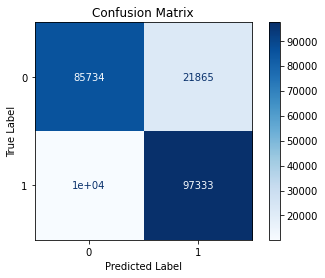

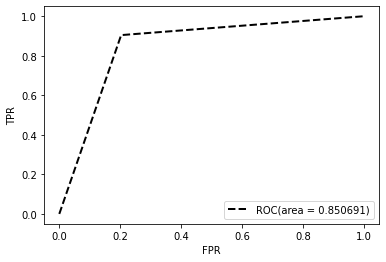

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=2, random_state=30)

xgb_model.fit(train_x_hashed, train_y)

# make predictions for test data
y_pred = xgb_model.predict(validation_x_hashed)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(validation_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

color = 'black'
matrix = plot_confusion_matrix(xgb_model, validation_x_hashed, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()



fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

precision_score
0.8548141070949177
recall_score
0.850690991551966


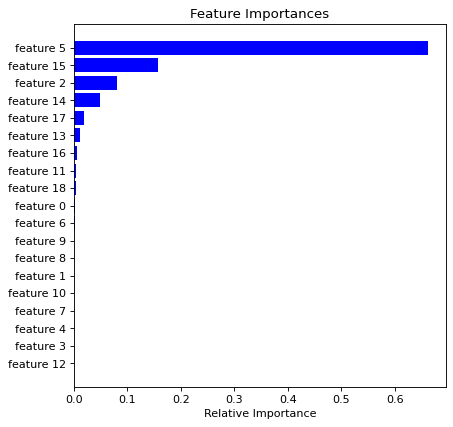

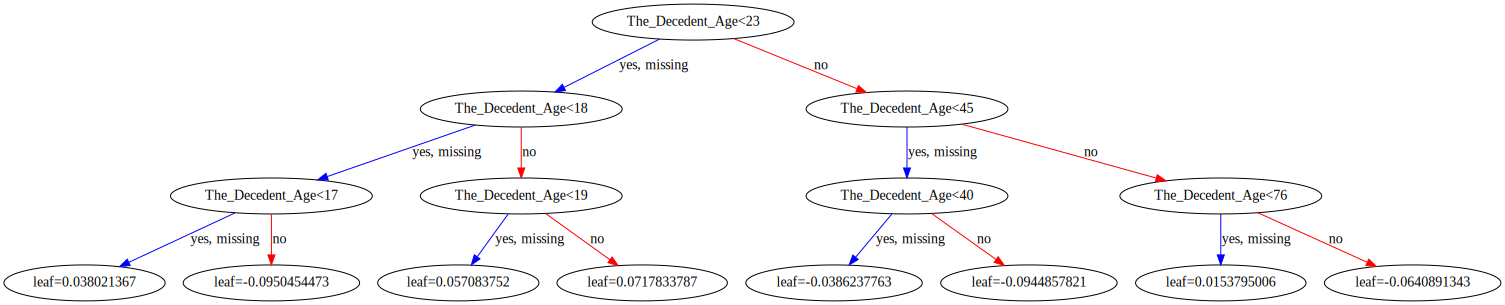

In [ ]:
print("precision_score")
print(precision_score(validation_y, y_pred, average='macro'))
print("recall_score")
print(recall_score(validation_y, y_pred, average='macro'))



figure(figsize=(6, 6), dpi=80)

features = [f"feature {i}" for i in range(train_x_hashed.shape[1])]
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



xgb.to_graphviz(xgb_model)

In [ ]:
dtrain = xgb.DMatrix(train_x_hashed, label=train_y)
params = {'objective': 'binary:logistic', 'eval_metric': 'error'}

# Perform 5-fold cross-validation
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics='error', early_stopping_rounds=10)

# Print the results
print(cv_results)

KeyboardInterrupt: ignored

In [ ]:
# Plot the training and test error
plt.plot(cv_results['train-error-mean'], label='Training Error')
plt.plot(cv_results['test-error-mean'], label='Test Error')

# Add a legend and labels
plt.legend()
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.title('XGBoost Cross-Validation Results')

# Show the plot
plt.show()

In [ ]:
category_features

In [ ]:
pdp = plot_partial_dependence(xgb_model, train_x_hashed, category_features, feature_names=category_features)
#fig, axs = plot_partial_dependence(model, X_train, features=['feature1', 'feature2'], feature_names=['Feature 1', 'Feature 2'])

In [ ]:
fig=pdp.figure_.set_size_inches(30, 30)

In [ ]:
pdp.figure_

In [ ]:
print(category_features[5])
print(category_features[15])
print(category_features[2])
print(category_features[13])
print(category_features[14])
print(category_features[17])
print(category_features[4])

General_Manner_of_death
The_Decedent_Marital_status
General_Place_of_death_and_decedents_status
The_Decedent_Sex
The_Decedent_Age
The_Decedent_Education
General_Data_year


# Logistic Regression

0.5292010148793205
0.7499747738944327


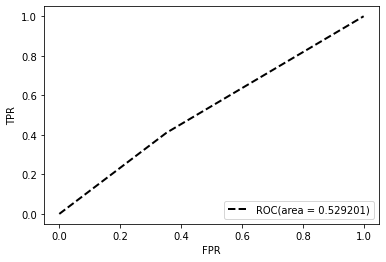

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression( penalty='l2', tol=0.001, C=2000,random_state=0, max_iter=500, solver='newton-cg').fit(train_x_hashed, train_y)
y_pred=lr_clf.predict(validation_x_hashed)
#y_pred
#lr_clf.predict_proba(train_x_norm)
print(lr_clf.score(validation_x_hashed, validation_y))
print(lr_clf.score(train_x_hashed, train_y))

fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


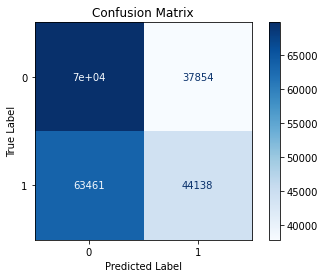

In [ ]:
color = 'black'
matrix = plot_confusion_matrix(lr_clf, validation_x_hashed, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [ ]:
print(precision_score(validation_y, y_pred, average='macro'))

print(recall_score(validation_y, y_pred, average='macro'))

0.5309541689369646
0.5292010148793205


# SVM

In [ ]:
from sklearn import svm

def support_vector_machine(train_x_hashed, train_y, validation_x, validation_y):
  clf = svm.SVC(C = 455000000, max_iter =  10000)
  clf.fit(train_x_hashed, train_y)
  y_pred = clf.predict(validation_x)
  accuracy = metrics.accuracy_score(validation_y, y_pred)
  return accuracy, y_pred, clf

In [ ]:
validation_accuracy, y_pred, svm_model = support_vector_machine(train_x_hashed, train_y, validation_x_hashed, validation_y)
print(validation_accuracy)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.5901541835890668


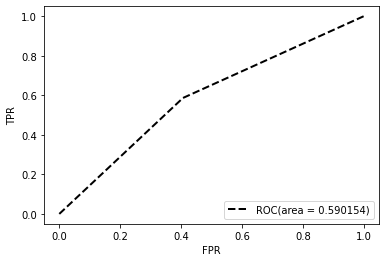

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

# KNN

In [ ]:
def KNN_test(train_x, train_y, validation_x, validation_y, k, m, n):
  KNN = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=m, leaf_size=n)
  KNN.fit(train_x, train_y)
  y_pred = KNN.predict(validation_x)
  acc = metrics.accuracy_score(validation_y, y_pred)
  model = KNN
  return acc, y_pred, model

In [ ]:
acc, y_pred, knn_model = KNN_test(train_x_hashed, train_y, validation_x_hashed, validation_y, k=5, m=15, n=40)
print('test accuracy:', acc)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
KNN = sklearn.neighbors.KNeighborsClassifier()

params = {'n_neighbors': [5, 6, 7, 8, 10, 15, 20], 'leaf_size': [20, 30, 40, 50], 'n_jobs' : [10, 15, 16, 18, 20]}

rs_model=RandomizedSearchCV(KNN,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

#model fitting
rs_model.fit(train_x_hashed, train_y)

#parameters selected
print(rs_model.best_estimator_)

print (rs_model.best_score_)


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

color = 'black'
matrix = plot_confusion_matrix(knn_model, validation_x_hashed, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('KNN Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(validation_y, y_pred, average='macro'))

print(recall_score(validation_y, y_pred, average='macro'))

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(train_x, train_y, validation_x, validation_y, n_est=100):
  clf = RandomForestClassifier(n_estimators = n_est, min_samples_split=2, min_samples_leaf=4, max_depth=90, bootstrap=True) 
  clf.fit(train_x, train_y)
  y_pred = clf.predict(validation_x)
  accuracy = metrics.accuracy_score(validation_y, y_pred)
  model = clf
  return accuracy, y_pred, model

0.8543713231535609


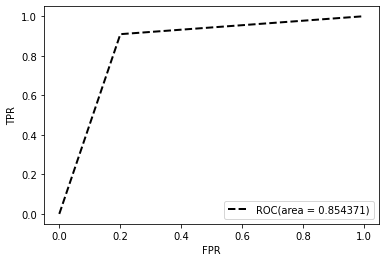

In [ ]:
validation_accuracy, y_pred,random_forest_model = random_forest(train_x_hashed, train_y, validation_x_hashed, validation_y, 30)
print(validation_accuracy)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


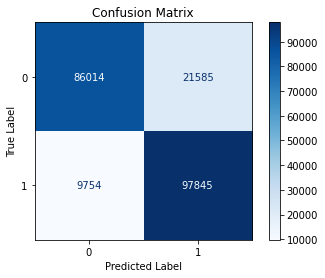

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

color = 'black'
matrix = plot_confusion_matrix(random_forest_model, validation_x_hashed, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(validation_y, y_pred, average='macro'))

print(recall_score(validation_y, y_pred, average='macro'))

0.8587081055236246
0.8543713231535609


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Create a search grid of parameters that will be shuffled through

n_estimators = [5, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 30, 35, 40] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9,10] # minimum sample number to split a node
min_samples_leaf = [1, 2, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(train_x_hashed, train_y)

print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [5, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 30, 35, 40], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}  



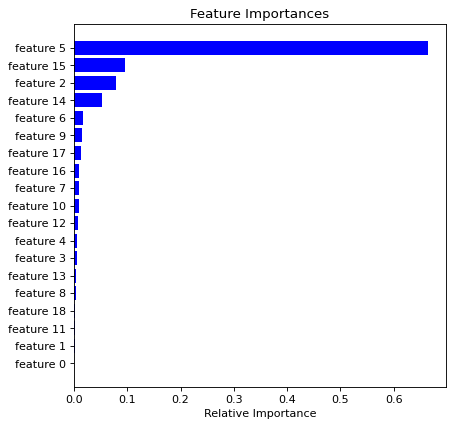

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(6, 6), dpi=80)

features = [f"feature {i}" for i in range(train_x.shape[1])]
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(random_forest_model.estimators_[0], out_file='tree.dot', 
                feature_names = train_x.columns, filled=True,
                rounded=True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in python
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('tree.png'))
plt.axis('off');
plt.show();

# Neural Network1

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential([
    Dense(units=12, input_dim=19,activation='relu'),
    Dense(units=9, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                240       
                                                                 
 dense_4 (Dense)             (None, 9)                 117       
                                                                 
 dense_5 (Dense)             (None, 1)                 10        
                                                                 
Total params: 367
Trainable params: 367
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_x_hashed, y=train_y, epochs=100)

Epoch 1/100
23538/23538 [==============================] - 39s 2ms/step - loss: 0.1897 - accuracy: 0.9483
Epoch 2/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1881 - accuracy: 0.9490
Epoch 3/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1858 - accuracy: 0.9497
Epoch 4/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1820 - accuracy: 0.9505
Epoch 5/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1789 - accuracy: 0.9507
Epoch 6/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1770 - accuracy: 0.9507
Epoch 7/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1761 - accuracy: 0.9507
Epoch 8/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1749 - accuracy: 0.9507
Epoch 9/100
23538/23538 [==============================] - 38s 2ms/step - loss: 0.1737 - accuracy: 0.9508
Epoch 10/100
23538/23538 [====================

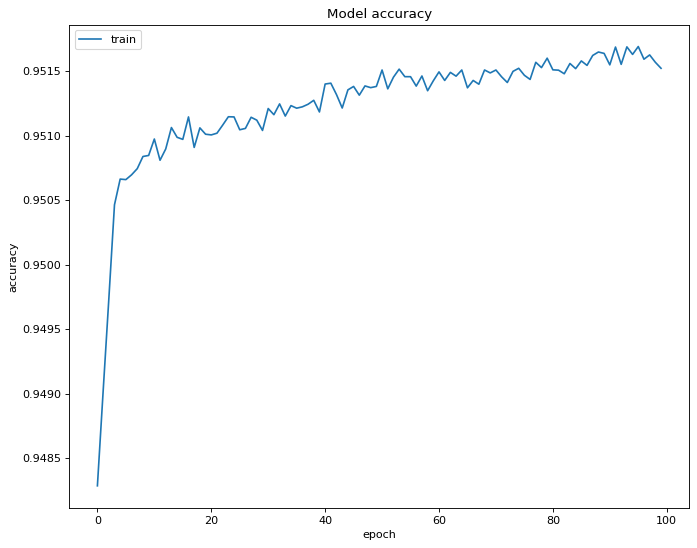

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

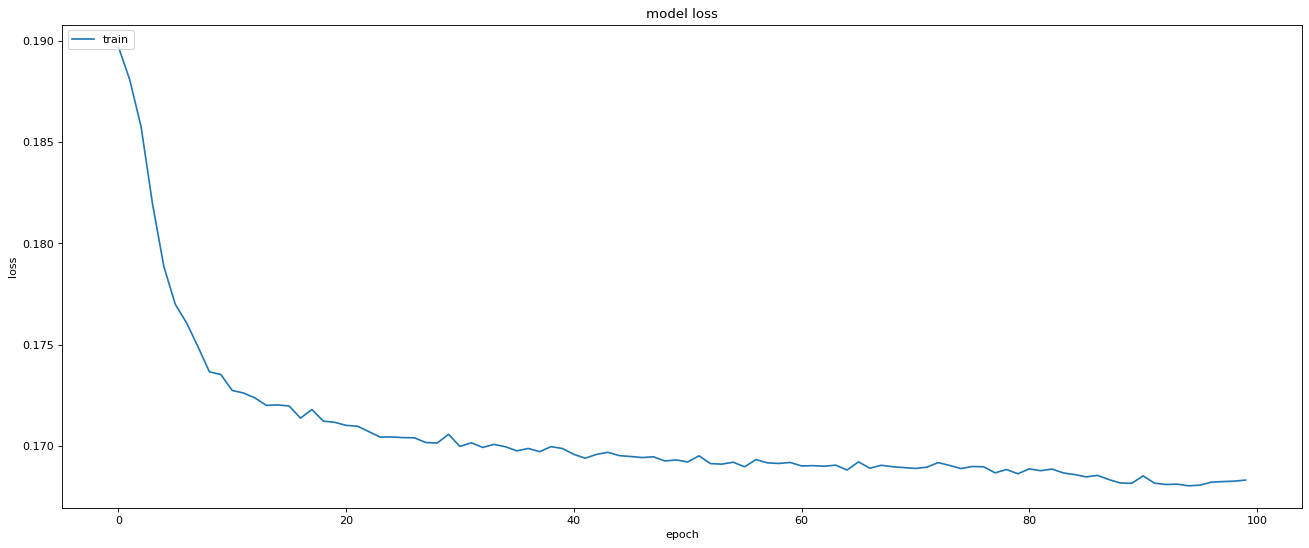

In [ ]:
# summarize history for loss
plt.figure(figsize=(20, 8), dpi=80)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

6725/6725 [==============================] - 7s 965us/step


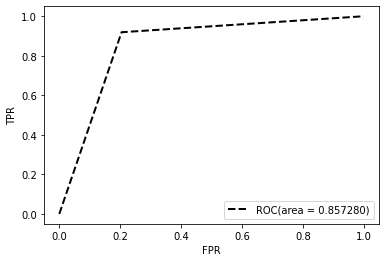

In [ ]:
y_pred = (model.predict(validation_x_hashed) > 0.5).astype("int32")

fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

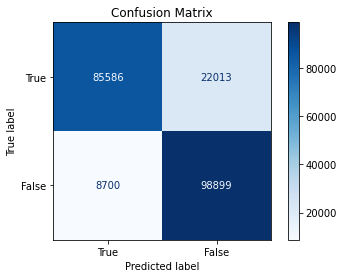

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay

color = 'black'
matrix = metrics.confusion_matrix(y_true=validation_y, y_pred=y_pred)  # shape=(12, 12)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['True', 'False'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', color=color)
plt.show()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(validation_y, y_pred, average='macro'))

print(recall_score(validation_y, y_pred, average='macro'))

0.8628347633345939
0.857280272121488


In [ ]:
acc = model.evaluate(x=validation_x_hashed, y=validation_y)

6725/6725 [==============================] - 8s 1ms/step - loss: 0.5077 - accuracy: 0.8573


# Correaltion Map

In [ ]:
original_data

,General_Record_Type,General_Resident_status,General_Place_of_death_and_decedents_status,General_Day_of_week_of_death,General_Data_year,General_Manner_of_death,Occurrence_State(FIPS),Occurrence_County(FIPS),Occurrence_County_Population_size,Residence_State(FIPS),...,The_Decedent_Date_of_Death,The_Decedent_Sex,The_Decedent_Age,The_Decedent_Marital_status,The_Decedent_State_or_country_of_birth,The_Decedent_Education,Underlying_Cause_ICD-10_code,The_Decedent_Race_Recode_5,The_Decedent_Hispanic_Origin/Race_Recode,The_Decedent_Race
0,2,2,6,6,2010,7,AK,020,2,AK,...,01,F,1068,D,AK AK,2,G049,3,8,3
1,1,1,4,1,2010,7,AK,170,4,AK,...,01,F,1012,S,AK AK,1,C37,1,6,1
2,1,1,4,1,2010,7,AK,170,4,AK,...,01,F,1075,D,OR OR,2,C719,1,6,1
3,1,1,4,6,2010,7,AK,020,2,AK,...,01,M,1061,W,ZZ YY,2,F03,4,8,4
4,1,1,4,7,2010,2,AK,170,4,AK,...,01,F,1046,M,CT CT,4,X72,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26459854,1,1,1,7,2019,7,NY,005,0,NY,...,05,M,1049,U,ZZ ZZ,9,K590,1,9,1
26459855,1,1,4,2,2019,7,NY,005,0,NY,...,10,M,1066,S,ZZ ZZ,9,C61,1,9,1
26459856,2,2,1,2,2019,7,NY,005,0,NY,...,12,M,1050,M,ZZ YY,8,D761,2,7,2
26459857,1,1,4,1,2019,7,NY,005,0,NY,...,12,F,1082,W,ZZ YY,3,E854,2,7,2


In [ ]:
original_data.corr()

""


In [ ]:

correlation_matrix = original_data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()


ValueError: ignored

<Figure size 864x648 with 0 Axes>

# Norm xgb


Accuracy: 88.15%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


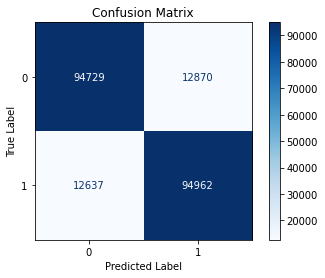

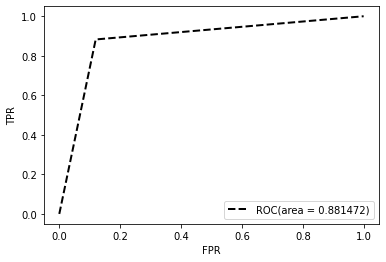

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=2, random_state=30)

xgb_model.fit(norm_train_x, train_y)

# make predictions for test data
y_pred = xgb_model.predict(norm_validation_x)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(validation_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

color = 'black'
matrix = plot_confusion_matrix(xgb_model, norm_validation_x, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()



fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()


0.881473735558005
0.8814719467653045


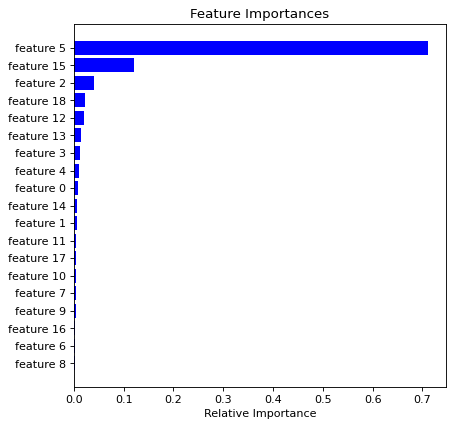

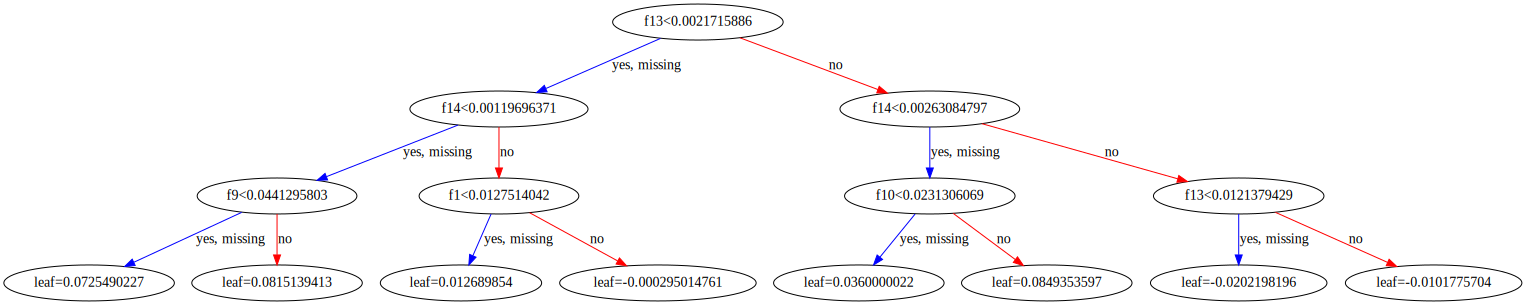

In [ ]:
print(precision_score(validation_y, y_pred, average='macro'))
print(recall_score(validation_y, y_pred, average='macro'))



figure(figsize=(6, 6), dpi=80)

features = [f"feature {i}" for i in range(norm_train_x.shape[1])]
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



xgb.to_graphviz(xgb_model)

In [ ]:
print(category_features[5])
print(category_features[15])
print(category_features[2])
print(category_features[18])
print(category_features[12])
print(category_features[13])
print(category_features[3])

General_Manner_of_death
The_Decedent_Marital_status
General_Place_of_death_and_decedents_status
The_Decedent_Race
The_Decedent_Date_of_Death
The_Decedent_Sex
General_Day_of_week_of_death


In [ ]:
dtrain = xgb.DMatrix(train_x_hashed, label=train_y)
params = {'objective': 'binary:logistic', 'eval_metric': 'error'}

# Perform 5-fold cross-validation
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics='error', early_stopping_rounds=10)

# Print the results
print(cv_results)

    train-error-mean  train-error-std  test-error-mean  test-error-std
0           0.047396         0.000249         0.047477        0.000995
1           0.047346         0.000278         0.047409        0.000983
2           0.047298         0.000240         0.047448        0.000999
3           0.046995         0.000211         0.047105        0.001080
4           0.046940         0.000219         0.047073        0.001072
..               ...              ...              ...             ...
95          0.041325         0.000249         0.043074        0.000927
96          0.041299         0.000245         0.043073        0.000918
97          0.041274         0.000249         0.043082        0.000927
98          0.041248         0.000252         0.043066        0.000917
99          0.041231         0.000258         0.043069        0.000933

[100 rows x 4 columns]


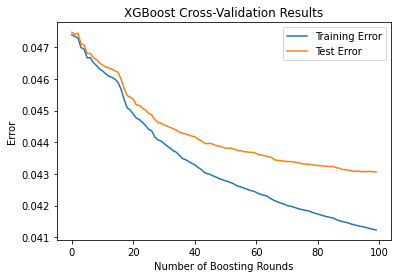

In [ ]:
# Plot the training and test error
plt.plot(cv_results['train-error-mean'], label='Training Error')
plt.plot(cv_results['test-error-mean'], label='Test Error')

# Add a legend and labels
plt.legend()
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.title('XGBoost Cross-Validation Results')

# Show the plot
plt.show()